In [2]:
import os
import math
import keras
import pickle
import random
import imageio
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import matplotlib.cm as cm
from keras import regularizers
import matplotlib.pyplot as plt
from keras.utils import Sequence
from keras.optimizers import Adam
from keras import optimizers, metrics
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
from keras import layers, models, applications
from sklearn.preprocessing import label_binarize
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import load_model, Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications import ResNet50, EfficientNetB1
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, GlobalAveragePooling2D, PReLU
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, roc_auc_score, classification_report


Shape of No Substructure: (64, 64)
Shape of Axion: (2,)
Shape of Cold Dark Matter (CDM): (64, 64)


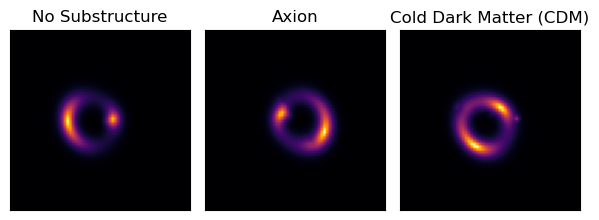

In [2]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(6, 4))

for i, (folder_path, title) in enumerate([
    ('Model_II/no_sub', 'No Substructure'),
    ('Model_II/axion', 'Axion'),
    ('Model_II/cdm', 'Cold Dark Matter (CDM)')]):
    file_name = os.listdir(folder_path)[7]
    file_path = os.path.join(folder_path, file_name)
    loaded_file = np.load(file_path, allow_pickle=True)
    print(f'Shape of {title}: {loaded_file.shape}') # Since the dataset states that 'Axion files have extra data corresponding to mass of axion used in simulation'. So the .npy file has a shape of 2, having the image and this mass.

    if (folder_path == 'Model_II/axion'):
        img_array = loaded_file[0]
    else:
        img_array = loaded_file
    axs[i].imshow(img_array, cmap='inferno')
    axs[i].set_title(title)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

plt.tight_layout()
plt.show()

In [3]:
# Algorithm hyperparameters
input_shape = (64, 64, 3)
num_epochs = 20
batch_size = 256 
width = 256
temperature = 0.1
queue_size = 10000

contrastive_augmentation_rotation = {"factor": 0.5,"name": "contrastive_augmenter_rotation"}
contrastive_augmentation_gaussian = {"std_dev": 0.1,"name": "contrastive_augmenter_gaussian"} # Std_dev = 0.04 for rgb and 0.001 for 1 channel


# classification_augmentation = {"brightness": 0.1,"name": "classification_augmenter","scale": (0.5, 3.0),}

# total_samples = sum([len(files) for r, d, files in os.walk(data_path)])
# steps_per_epoch = total_samples // batch_size
# validation_steps = total_samples // batch_size


In [4]:
classes = ['axion', 'cdm', 'no_sub']
class_indices = {class_name: idx for idx, class_name in enumerate(classes)}

def image_generator(files, label_type, batch_size = batch_size):
    while True:
        # Select files (paths/indices) for the batch
        batch_paths = np.random.choice(a = files, size = batch_size)
        batch_input = []
        batch_output = []

        # Read in each input, perform preprocessing and get labels
        for input_path in batch_paths:
            class_name = os.path.basename(os.path.dirname(input_path))
            label = class_indices[class_name] 
            if class_name == 'axion':
                input = np.load(input_path, allow_pickle=True)[0][..., np.newaxis]
            else:
                input = np.load(input_path, allow_pickle=False)[..., np.newaxis]
                
            img_3d = np.repeat(input, 3, axis=-1) # For RGB channel
            img_3d  = (img_3d - np.min(img_3d)) / (np.max(img_3d) - np.min(img_3d)) # For RGB channel
            batch_input += [ img_3d ] # For RGB channel
#             batch_input += [ input ] # For Single channel
            batch_output += [ label ]
    
        batch_x = np.array(batch_input)
        if label_type == 'one_hot':
            batch_y = to_categorical(batch_output, num_classes=3)  # Perform one-hot encoding
        elif label_type == 'label':
            batch_y = np.array(batch_output)
        # print(batch_x.shape,batch_y.shape)
        yield(batch_x, batch_y)

# Get all file paths in the data_path
data_path = 'Model_II/' 
file_paths = []
for class_name in classes:
    class_dir = os.path.join(data_path, class_name)
    file_paths += [os.path.join(class_dir, file) for file in os.listdir(class_dir)]


train_files, test_files = train_test_split(file_paths, test_size=0.1, random_state=69)

train_generator_one_hot = image_generator(train_files, label_type = 'one_hot', batch_size=batch_size)
test_generator_one_hot = image_generator(test_files, label_type = 'one_hot', batch_size=batch_size)

train_generator_label = image_generator(train_files,label_type = 'label',  batch_size=batch_size)
test_generator_label = image_generator(test_files,label_type = 'label',  batch_size=batch_size)

total_samples = len(train_files)
steps_per_epoch = total_samples // batch_size
total_validation_samples = len(test_files)
validation_steps = total_validation_samples // batch_size

Array Range: 0.0, 1.0
Sample Image of label no_sub: 


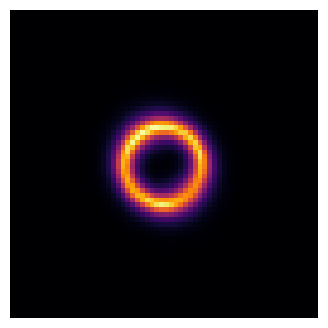

Image shape: (256, 64, 64, 3)
Label shape: (256, 3)


In [5]:
image_sample, label_sample = next(train_generator_one_hot)
print(f'Array Range: {np.min(image_sample[0])}, {np.max(image_sample[0])}')
print(f'Sample Image of label {"axion" if np.argmax(label_sample[0]) == 0 else "cdm" if np.argmax(label_sample[0]) == 1 else "no_sub"}: ')
plt.figure(figsize=(4,4))
plt.imshow(np.mean(image_sample[0], axis=2), cmap='inferno') # np.mean() is used to convert the rgb image to greyscale so we can apply cmap to it.
plt.axis('off')
plt.show()
print(f'Image shape: {image_sample.shape}\nLabel shape: {label_sample.shape}')


In [5]:
class RandomResizedCrop(layers.Layer):
    def __init__(self, scale, ratio):
        super().__init__()
        self.scale = scale
        self.log_ratio = (tf.math.log(ratio[0]), tf.math.log(ratio[1]))

    def call(self, images):
        batch_size = tf.shape(images)[0]
        height = tf.shape(images)[1]
        width = tf.shape(images)[2]

        random_scales = tf.random.uniform((batch_size,), self.scale[0], self.scale[1])
        random_ratios = tf.exp(
            tf.random.uniform((batch_size,), self.log_ratio[0], self.log_ratio[1])
        )

        new_heights = tf.clip_by_value(tf.sqrt(random_scales / random_ratios), 0, 1)
        new_widths = tf.clip_by_value(tf.sqrt(random_scales * random_ratios), 0, 1)
        height_offsets = tf.random.uniform((batch_size,), 0, 1 - new_heights)
        width_offsets = tf.random.uniform((batch_size,), 0, 1 - new_widths)

        bounding_boxes = tf.stack(
            [
                height_offsets,
                width_offsets,
                height_offsets + new_heights,
                width_offsets + new_widths,
            ],
            axis=1,
        )
        images = tf.image.crop_and_resize(
            images, bounding_boxes, tf.range(batch_size), (height, width)
        )
        return images
    
class RandomGaussianNoise(layers.Layer):
    def __init__(self, std_dev):
        super().__init__()
        self.std_dev = std_dev

    def add_gaussian_noise(self, images):
        noise = tf.random.normal(shape=tf.shape(images), mean=0., stddev=self.std_dev)
        return tf.clip_by_value(images + noise, 0, 1)

    def call(self, images):
        images = self.add_gaussian_noise(images)
        return images

    
    
def get_augmenter_only_gaussian(std_dev, name):
    return keras.Sequential(
        [
            layers.Input(shape=input_shape),
            # layers.Rescaling(1 / 255), # Only for Single Channel Images
#             layers.RandomRotation(1), # Not needed for now
            RandomGaussianNoise(std_dev=std_dev),
#             RandomResizedCrop(scale=scale, ratio=(3 / 4, 4 / 3)),
#             RandomBrightness(brightness=brightness),
        ],
        name=name,)

def get_augmenter_only_rotation(factor, name):
    return keras.Sequential(
        [
            layers.Input(shape=input_shape),
            layers.RandomRotation(factor), 
        ],
        name=name,)

class RandomBrightness(layers.Layer):
    def __init__(self, brightness):
        super().__init__()
        self.brightness = brightness
    def blend(self, images_1, images_2, ratios):
        return tf.clip_by_value(ratios * images_1 + (1.0 - ratios) * images_2, 0, 1)
    def random_brightness(self, images):
        # random interpolation/extrapolation between the image and darkness
        return self.blend(
            images,
            0,
            tf.random.uniform(
                (tf.shape(images)[0], 1, 1, 1), 1 - self.brightness, 1 + self.brightness),)
    def call(self, images):
        images = self.random_brightness(images)
        return images 

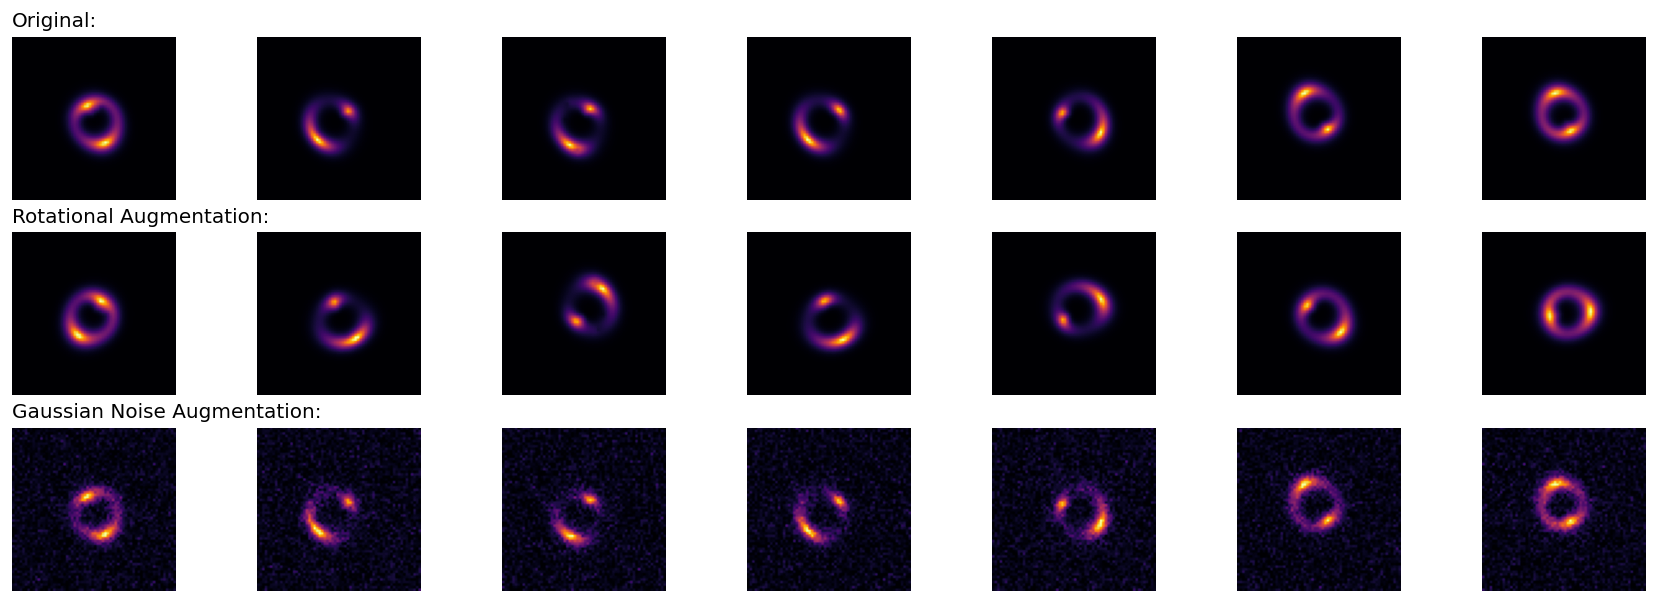

In [43]:
def visualize_augmentations(num_images):
    # Sample a batch from a dataset
    images = next(train_generator_one_hot)[0][:num_images]
    augmented_images = zip(
        images,
        get_augmenter_only_rotation(**contrastive_augmentation_rotation)(images),
        get_augmenter_only_gaussian(**contrastive_augmentation_gaussian)(images),
    )
    row_titles = [
        "Original:",
        "Rotational Augmentation:",
        "Gaussian Noise Augmentation:",
    ]
    plt.figure(figsize=(18, 6), dpi=120)
    for column, image_row in enumerate(augmented_images):
        for row, image in enumerate(image_row):
            plt.subplot(3, num_images, row * num_images + column + 1)
            plt.imshow(np.mean(image, axis=2), cmap='inferno')
            if column == 0:
                plt.title(row_titles[row], loc="left")
            plt.axis("off")

visualize_augmentations(num_images=7)

### Baseline Training


In [6]:
def get_encoder():
    resnet = applications.ResNet50(weights=None, include_top=False, input_shape=input_shape)
#     for layer in resnet.layers:
#         layer.trainable = False
    model = models.Sequential([
          resnet,
          layers.GlobalAveragePooling2D(),
          layers.Dense(width*8,  activation='relu'), #256*8 = 2048
          layers.BatchNormalization(), 
          layers.Dropout(0.5),
        
          layers.Dense(width*4,  activation='relu'), #256*4 = 1024
          layers.BatchNormalization(),
          layers.Dropout(0.5),
        
          layers.Dense(width,  activation='relu'), #512
          layers.BatchNormalization(),
          layers.Dropout(0.3),
    ])
    return model


In [10]:
baseline_model = keras.Sequential(
    [ 
        get_encoder(),
        layers.Dense(3, activation='softmax'),
    ],
    name="baseline_model",
)
baseline_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate= 1e-4),
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['acc', metrics.AUC(name='auc')])

baseline_history = baseline_model.fit(train_generator_one_hot, steps_per_epoch=steps_per_epoch, epochs=num_epochs, 
                                      validation_data=test_generator_one_hot, validation_steps = validation_steps)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(baseline_history.history["val_acc"]) * 100
    )
)

Epoch 1/20
313/313 [==============================] - 258s 800ms/step - loss: 1.0718 - acc: 0.5453 - auc: 0.7391 - val_loss: 1.5032 - val_acc: 0.3197 - val_auc: 0.4846
Epoch 2/20
313/313 [==============================] - 211s 676ms/step - loss: 0.5202 - acc: 0.8009 - auc: 0.9295 - val_loss: 1.6334 - val_acc: 0.3370 - val_auc: 0.5244
Epoch 3/20
313/313 [==============================] - 202s 648ms/step - loss: 0.4243 - acc: 0.8344 - auc: 0.9500 - val_loss: 0.5765 - val_acc: 0.7571 - val_auc: 0.9127
Epoch 4/20
313/313 [==============================] - 199s 638ms/step - loss: 0.3914 - acc: 0.8450 - auc: 0.9563 - val_loss: 0.4409 - val_acc: 0.8185 - val_auc: 0.9469
Epoch 5/20
313/313 [==============================] - 209s 669ms/step - loss: 0.3646 - acc: 0.8561 - auc: 0.9613 - val_loss: 0.5415 - val_acc: 0.7938 - val_auc: 0.9271
Epoch 6/20
313/313 [==============================] - 201s 642ms/step - loss: 0.3504 - acc: 0.8613 - auc: 0.9639 - val_loss: 0.3822 - val_acc: 0.8336 - val_auc:

In [11]:
baseline_model.save_weights('baseline_model_resnet50.h5')
# loaded_model = ContrastiveModel()
# pretraining_model.load_weights('pretraining_model.h5')
with open('baseline_history_resnet50.pkl', 'wb') as file:
    pickle.dump(baseline_history.history, file)

### Self-Supervised Contrastive Pretraining


c_loss: Contrastive loss. It is a measure of dissimilarity between pairs of augmented images. This loss is calculated using the InfoNCE (Information Noise-Contrastive Estimation) or NT-Xent (Normalized Temperature-Scaled Cross Entropy) loss, which encourages similar representations for augmented views of the same image and dissimilar representations for different images.

c_acc: Contrastive accuracy. It measures the accuracy of the contrastive predictions. In this case, it represents how well the model is able to distinguish between the representations of augmented views of the same image and different images.

p_loss: Probe loss. It is the loss for the linear probe, which is used for evaluation and downstream classification tasks. The probe loss is calculated using the sparse categorical cross-entropy loss, comparing the predicted class probabilities with the true labels.

p_acc: Probe accuracy. It represents the accuracy of the linear probe, indicating how well the model performs on the downstream classification task.

### With only Rotational

In [126]:
# Define the contrastive model with model-subclassing
class ContrastiveModel(keras.Model):
    def __init__(self):
        super().__init__()

        self.temperature = temperature
        self.contrastive_augmenter = get_augmenter_only_rotation(**contrastive_augmentation_rotation)
        self.encoder = get_encoder()
        # Non-linear MLP as projection head
        self.projection_head = keras.Sequential(
            [
                keras.Input(shape=(width,)),
                layers.Dense(width, activation="relu"),
                layers.Dense(width),
            ],
            name="projection_head",
        )
        # Single dense layer for linear probing
        self.linear_probe = keras.Sequential(
            [layers.Input(shape=(width,)), layers.Dense(3)], name="linear_probe"
        )

        self.encoder.summary()
        self.projection_head.summary()
        self.linear_probe.summary()

    def compile(self, contrastive_optimizer, probe_optimizer, **kwargs):
        super().compile(**kwargs)

        self.contrastive_optimizer = contrastive_optimizer
        self.probe_optimizer = probe_optimizer

        # self.contrastive_loss will be defined as a method
        self.probe_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        self.contrastive_loss_tracker = keras.metrics.Mean(name="c_loss")
        self.contrastive_accuracy = keras.metrics.SparseCategoricalAccuracy(
            name="c_acc"
        )
        self.probe_loss_tracker = keras.metrics.Mean(name="p_loss")
        self.probe_accuracy = keras.metrics.SparseCategoricalAccuracy(name="p_acc")

    @property
    def metrics(self):
        return [
            self.contrastive_loss_tracker,
            self.contrastive_accuracy,
            self.probe_loss_tracker,
            self.probe_accuracy,
        ]

    def contrastive_loss(self, projections_1, projections_2):
        # InfoNCE loss (information noise-contrastive estimation)
        # NT-Xent loss (normalized temperature-scaled cross entropy)

        # Cosine similarity: the dot product of the l2-normalized feature vectors
        projections_1 = tf.math.l2_normalize(projections_1, axis=1)
        projections_2 = tf.math.l2_normalize(projections_2, axis=1)
        similarities = (
            tf.matmul(projections_1, projections_2, transpose_b=True) / self.temperature
        )

        # The similarity between the representations of two augmented views of the
        # same image should be higher than their similarity with other views
        batch_size = tf.shape(projections_1)[0]
        contrastive_labels = tf.range(batch_size)
        self.contrastive_accuracy.update_state(contrastive_labels, similarities)
        self.contrastive_accuracy.update_state(
            contrastive_labels, tf.transpose(similarities)
        )

        # The temperature-scaled similarities are used as logits for cross-entropy
        # a symmetrized version of the loss is used here
        loss_1_2 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, similarities, from_logits=True
        )
        loss_2_1 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, tf.transpose(similarities), from_logits=True
        )
        return (loss_1_2 + loss_2_1) / 2

    def train_step(self, data):
        labeled_images, labels = data

        # Each image is augmented twice, differently
        augmented_images_1 = self.contrastive_augmenter(labeled_images)
        augmented_images_2 = self.contrastive_augmenter(labeled_images)
        with tf.GradientTape() as tape:
            features_1 = self.encoder(augmented_images_1, training=True)
            features_2 = self.encoder(augmented_images_2, training=True)
            # The representations are passed through a projection mlp
            projections_1 = self.projection_head(features_1, training=True)
            projections_2 = self.projection_head(features_2, training=True)
            contrastive_loss = self.contrastive_loss(projections_1, projections_2)
        gradients = tape.gradient(
            contrastive_loss,
            self.encoder.trainable_weights + self.projection_head.trainable_weights,
        )
        self.contrastive_optimizer.apply_gradients(
            zip(
                gradients,
                self.encoder.trainable_weights + self.projection_head.trainable_weights,
            )
        )
        self.contrastive_loss_tracker.update_state(contrastive_loss)

        # Labels are only used in evalutation for an on-the-fly logistic regression
#         preprocessed_images = self.classification_augmenter(
#             labeled_images, training=True
#         )
        
        with tf.GradientTape() as tape:
            # the encoder is used in inference mode here to avoid regularization
            # and updating the batch normalization paramers if they are used
            features = self.encoder(labeled_images, training=False) #preprocessed_images replaced with labeled_images
            class_logits = self.linear_probe(features, training=True)
            probe_loss = self.probe_loss(labels, class_logits)
        gradients = tape.gradient(probe_loss, self.linear_probe.trainable_weights)
        self.probe_optimizer.apply_gradients(
            zip(gradients, self.linear_probe.trainable_weights)
        )
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        labeled_images, labels = data

        # For testing the components are used with a training=False flag
#         preprocessed_images = self.classification_augmenter(
#             labeled_images, training=False
#         )
        features = self.encoder(labeled_images, training=False) #preprocessed_images replaced with labeled_images
        class_logits = self.linear_probe(features, training=False)
        probe_loss = self.probe_loss(labels, class_logits)
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        # Only the probe metrics are logged at test time
        return {m.name: m.result() for m in self.metrics[2:]}


# Contrastive pretraining
pretraining_model = ContrastiveModel()
pretraining_model.compile(
    contrastive_optimizer=keras.optimizers.Adam(),
    probe_optimizer=keras.optimizers.Adam(),
)

pretraining_history = pretraining_model.fit(train_generator_label, steps_per_epoch=steps_per_epoch, epochs=num_epochs, 
                                            validation_data=test_generator_label, validation_steps = validation_steps)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(pretraining_history.history["val_p_acc"]) * 100
    )
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_18 (Dense)            (None, 2048)              4196352   
                                                                 
 batch_normalization_9 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dropout_9 (Dropout)         (None, 2048)              0         
                                                                 
 dense_19 (Dense)            (None, 1024)             

In [12]:
pretraining_model.save_weights('pretraining_model_rotational.h5')
with open('pretraining_history_rotational.pkl', 'wb') as file:
    pickle.dump(pretraining_history.history, file)

In [13]:
finetuning_model_rotation = keras.Sequential(
    [
        pretraining_model.encoder,
        layers.Dense(3, activation='softmax'),
    ],
    name="finetuning_model_rotation",
)
finetuning_model_rotation.compile(
    optimizer=keras.optimizers.Adam(learning_rate= 1e-4),
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['acc', metrics.AUC(name='auc')])

finetuning_history_rotation = finetuning_model_rotation.fit(train_generator_one_hot, steps_per_epoch=steps_per_epoch, epochs=num_epochs, 
                                          validation_data=test_generator_one_hot, validation_steps = validation_steps)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(finetuning_history_rotation.history["val_acc"]) * 100
    )
)

Epoch 1/20
313/313 [==============================] - 232s 716ms/step - loss: 0.6339 - acc: 0.7308 - auc: 0.8971 - val_loss: 24.4938 - val_acc: 0.4038 - val_auc: 0.5505
Epoch 2/20
313/313 [==============================] - 239s 764ms/step - loss: 0.2854 - acc: 0.8876 - auc: 0.9763 - val_loss: 0.3766 - val_acc: 0.8351 - val_auc: 0.9629
Epoch 3/20
313/313 [==============================] - 203s 649ms/step - loss: 0.2618 - acc: 0.8938 - auc: 0.9799 - val_loss: 0.2885 - val_acc: 0.8946 - val_auc: 0.9783
Epoch 4/20
313/313 [==============================] - 199s 639ms/step - loss: 0.2359 - acc: 0.9012 - auc: 0.9834 - val_loss: 0.2689 - val_acc: 0.8980 - val_auc: 0.9803
Epoch 5/20
313/313 [==============================] - 199s 638ms/step - loss: 0.2319 - acc: 0.9014 - auc: 0.9837 - val_loss: 0.5045 - val_acc: 0.8763 - val_auc: 0.9598
Epoch 6/20
313/313 [==============================] - 198s 633ms/step - loss: 0.2142 - acc: 0.9112 - auc: 0.9862 - val_loss: 5.6905 - val_acc: 0.6719 - val_auc

In [14]:
finetuning_model_rotation.save_weights('finetuning_model_rotation.h5')
# loaded_model = ContrastiveModel()
# pretraining_model.load_weights('pretraining_model.h5')
with open('finetuning_history_rotation.pkl', 'wb') as file:
    pickle.dump(finetuning_history_rotation.history, file)

### With Gaussian blur

In [101]:
# Define the contrastive model with model-subclassing
class ContrastiveModel(keras.Model):
    def __init__(self):
        super().__init__()

        self.temperature = temperature
        self.contrastive_augmenter = get_augmenter_only_gaussian(**contrastive_augmentation_gaussian)
        self.encoder = get_encoder()
        # Non-linear MLP as projection head
        self.projection_head = keras.Sequential(
            [
                keras.Input(shape=(width,)),
                layers.Dense(width, activation="relu"),
                layers.Dense(width),
            ],
            name="projection_head",
        )
        # Single dense layer for linear probing
        self.linear_probe = keras.Sequential(
            [layers.Input(shape=(width,)), layers.Dense(3)], name="linear_probe"
        )

        self.encoder.summary()
        self.projection_head.summary()
        self.linear_probe.summary()

    def compile(self, contrastive_optimizer, probe_optimizer, **kwargs):
        super().compile(**kwargs)

        self.contrastive_optimizer = contrastive_optimizer
        self.probe_optimizer = probe_optimizer

        # self.contrastive_loss will be defined as a method
        self.probe_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        self.contrastive_loss_tracker = keras.metrics.Mean(name="c_loss")
        self.contrastive_accuracy = keras.metrics.SparseCategoricalAccuracy(
            name="c_acc"
        )
        self.probe_loss_tracker = keras.metrics.Mean(name="p_loss")
        self.probe_accuracy = keras.metrics.SparseCategoricalAccuracy(name="p_acc")

    @property
    def metrics(self):
        return [
            self.contrastive_loss_tracker,
            self.contrastive_accuracy,
            self.probe_loss_tracker,
            self.probe_accuracy,
        ]

    def contrastive_loss(self, projections_1, projections_2):
        # InfoNCE loss (information noise-contrastive estimation)
        # NT-Xent loss (normalized temperature-scaled cross entropy)

        # Cosine similarity: the dot product of the l2-normalized feature vectors
        projections_1 = tf.math.l2_normalize(projections_1, axis=1)
        projections_2 = tf.math.l2_normalize(projections_2, axis=1)
        similarities = (
            tf.matmul(projections_1, projections_2, transpose_b=True) / self.temperature
        )

        # The similarity between the representations of two augmented views of the
        # same image should be higher than their similarity with other views
        batch_size = tf.shape(projections_1)[0]
        contrastive_labels = tf.range(batch_size)
        self.contrastive_accuracy.update_state(contrastive_labels, similarities)
        self.contrastive_accuracy.update_state(
            contrastive_labels, tf.transpose(similarities)
        )

        # The temperature-scaled similarities are used as logits for cross-entropy
        # a symmetrized version of the loss is used here
        loss_1_2 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, similarities, from_logits=True
        )
        loss_2_1 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, tf.transpose(similarities), from_logits=True
        )
        return (loss_1_2 + loss_2_1) / 2

    def train_step(self, data):
        labeled_images, labels = data

        # Each image is augmented twice, differently
        augmented_images_1 = self.contrastive_augmenter(labeled_images)
        augmented_images_2 = self.contrastive_augmenter(labeled_images)
        with tf.GradientTape() as tape:
            features_1 = self.encoder(augmented_images_1, training=True)
            features_2 = self.encoder(augmented_images_2, training=True)
            # The representations are passed through a projection mlp
            projections_1 = self.projection_head(features_1, training=True)
            projections_2 = self.projection_head(features_2, training=True)
            contrastive_loss = self.contrastive_loss(projections_1, projections_2)
        gradients = tape.gradient(
            contrastive_loss,
            self.encoder.trainable_weights + self.projection_head.trainable_weights,
        )
        self.contrastive_optimizer.apply_gradients(
            zip(
                gradients,
                self.encoder.trainable_weights + self.projection_head.trainable_weights,
            )
        )
        self.contrastive_loss_tracker.update_state(contrastive_loss)

        # Labels are only used in evalutation for an on-the-fly logistic regression
#         preprocessed_images = self.classification_augmenter(
#             labeled_images, training=True
#         )
        
        with tf.GradientTape() as tape:
            # the encoder is used in inference mode here to avoid regularization
            # and updating the batch normalization paramers if they are used
            features = self.encoder(labeled_images, training=False) #preprocessed_images replaced with labeled_images
            class_logits = self.linear_probe(features, training=True)
            probe_loss = self.probe_loss(labels, class_logits)
        gradients = tape.gradient(probe_loss, self.linear_probe.trainable_weights)
        self.probe_optimizer.apply_gradients(
            zip(gradients, self.linear_probe.trainable_weights)
        )
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        labeled_images, labels = data

        # For testing the components are used with a training=False flag
#         preprocessed_images = self.classification_augmenter(
#             labeled_images, training=False
#         )
        features = self.encoder(labeled_images, training=False) #preprocessed_images replaced with labeled_images
        class_logits = self.linear_probe(features, training=False)
        probe_loss = self.probe_loss(labels, class_logits)
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        # Only the probe metrics are logged at test time
        return {m.name: m.result() for m in self.metrics[2:]}


# Contrastive pretraining
pretraining_model_gaussian = ContrastiveModel()
pretraining_model_gaussian.compile(
    contrastive_optimizer=keras.optimizers.Adam(),
    probe_optimizer=keras.optimizers.Adam(),
)

pretraining_history_gaussian = pretraining_model_gaussian.fit(train_generator_label, steps_per_epoch=steps_per_epoch, epochs=num_epochs, 
                                            validation_data=test_generator_label, validation_steps = validation_steps)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(pretraining_history_gaussian.history["val_p_acc"]) * 100
    )
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_11 (Dense)            (None, 2048)              4196352   
                                                                 
 batch_normalization_6 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 2048)              0         
                                                                 
 dense_12 (Dense)            (None, 1024)             

In [107]:
pretraining_model_gaussian.save_weights('pretraining_model_gaussian.h5')
with open('pretraining_history_gaussian.pkl', 'wb') as file:
    pickle.dump(pretraining_history_gaussian.history, file)


In [106]:
finetuning_model_gaussian = keras.Sequential(
    [
        pretraining_model_gaussian.encoder,
        layers.Dense(3, activation='softmax'),
    ],
    name="finetuning_model",
)
finetuning_model_gaussian.compile(
    optimizer=keras.optimizers.Adam(learning_rate= 1e-4),
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['acc', metrics.AUC(name='auc')])

finetuning_history_gaussian = finetuning_model_gaussian.fit(train_generator_one_hot, steps_per_epoch=steps_per_epoch, epochs=num_epochs, 
                                          validation_data=test_generator_one_hot, validation_steps = validation_steps)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(finetuning_history_gaussian.history["val_acc"]) * 100
    )
)

Epoch 1/20
313/313 [==============================] - 266s 830ms/step - loss: 0.7321 - acc: 0.6834 - auc: 0.8620 - val_loss: 0.4474 - val_acc: 0.8285 - val_auc: 0.9469
Epoch 2/20
313/313 [==============================] - 240s 768ms/step - loss: 0.3952 - acc: 0.8455 - auc: 0.9556 - val_loss: 0.3161 - val_acc: 0.8751 - val_auc: 0.9705
Epoch 3/20
313/313 [==============================] - 194s 620ms/step - loss: 0.3426 - acc: 0.8614 - auc: 0.9658 - val_loss: 0.3520 - val_acc: 0.8631 - val_auc: 0.9658
Epoch 4/20
313/313 [==============================] - 194s 622ms/step - loss: 0.3182 - acc: 0.8677 - auc: 0.9700 - val_loss: 0.3394 - val_acc: 0.8727 - val_auc: 0.9681
Epoch 5/20
313/313 [==============================] - 183s 587ms/step - loss: 0.2996 - acc: 0.8771 - auc: 0.9732 - val_loss: 0.3298 - val_acc: 0.8498 - val_auc: 0.9670
Epoch 6/20
313/313 [==============================] - 206s 660ms/step - loss: 0.2852 - acc: 0.8802 - auc: 0.9754 - val_loss: 0.2608 - val_acc: 0.8886 - val_auc:

In [108]:
finetuning_model_gaussian.save_weights('finetuning_model_gaussian.h5')
with open('finetuning_history_gaussian.pkl', 'wb') as file:
    pickle.dump(finetuning_history_gaussian.history, file)


### Results

In [11]:
with open("history/baseline_history_resnet50.pkl", "rb") as f:
    baseline_history = pickle.load(f)
with open("history/finetuning_history_rotation.pkl", "rb") as f:
    finetuning_history_rotation = pickle.load(f)
with open("history/finetuning_history_gaussian.pkl", "rb") as f:
    finetuning_history_gaussian = pickle.load(f)   

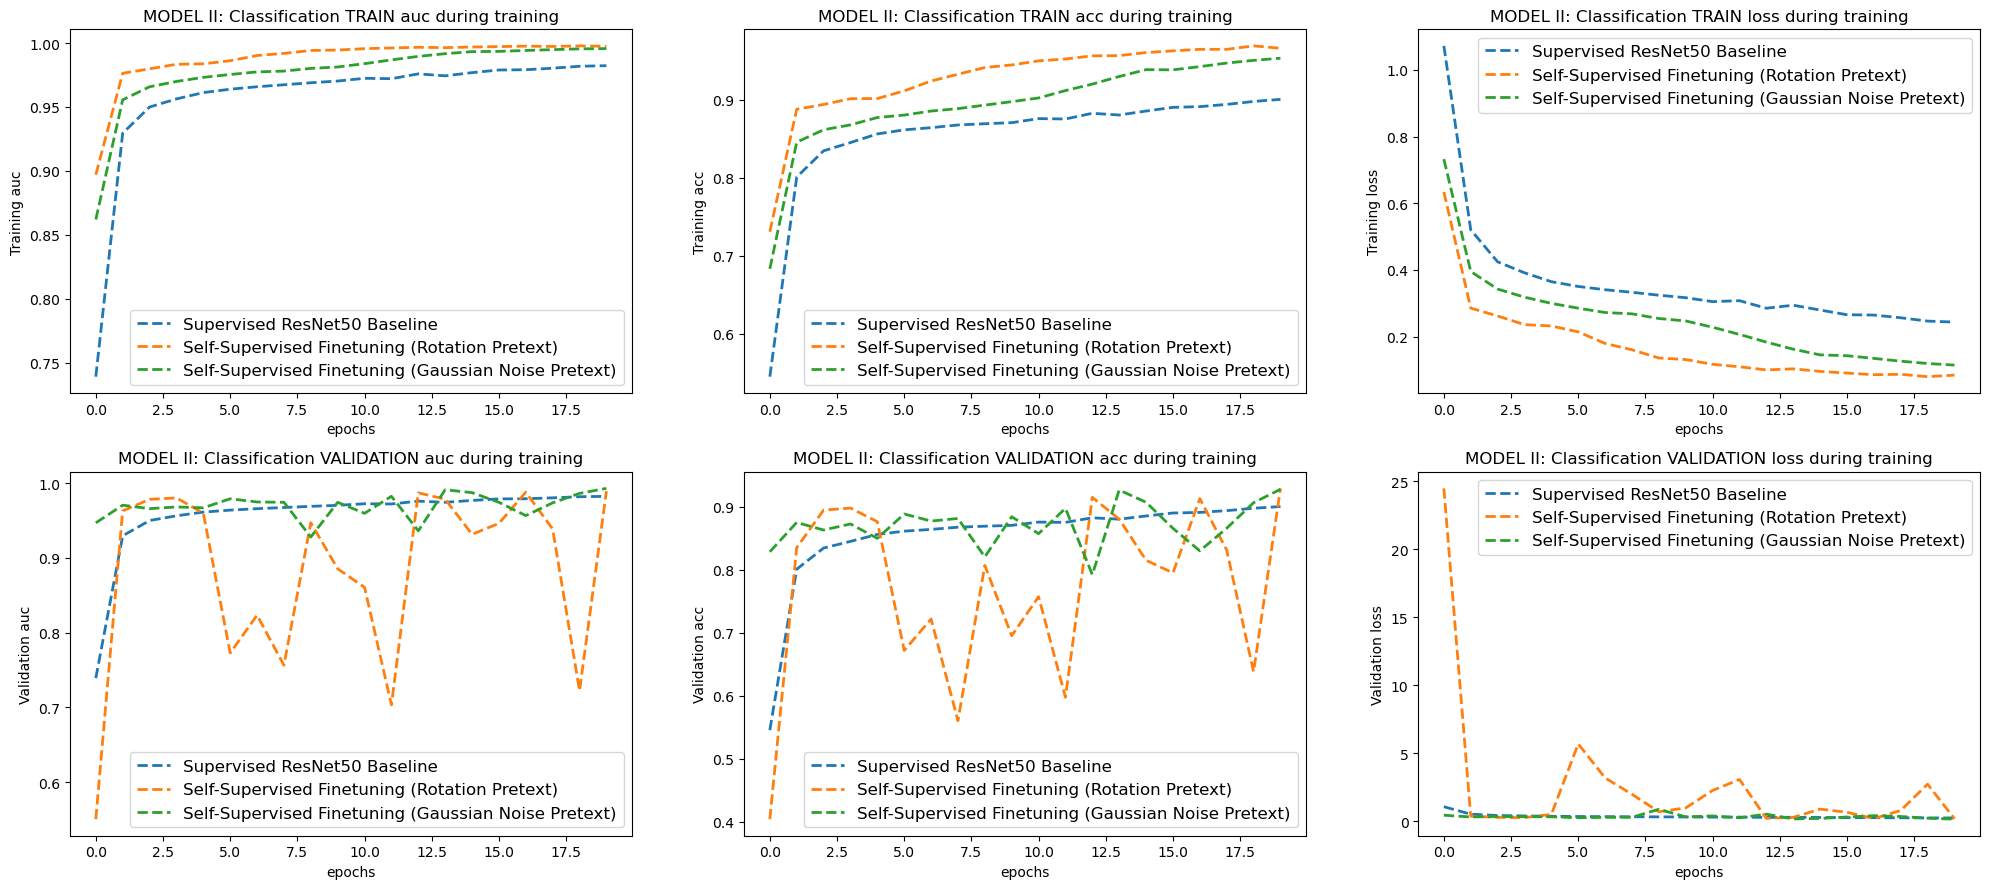

In [12]:
def plot_training_curves(baseline_history, finetuning_history_rotation, finetuning_history_gaussian):
    fig, axes = plt.subplots(2, 3, figsize=(20, 9), dpi=100)
    
    metric_keys = ["auc", "acc", "loss"]
    metric_names = ["auc", "acc", "loss"]
    
    # Plotting for MODEL II Training
    for i, (metric_key, metric_name) in enumerate(zip(metric_keys, metric_names)):
        axes[0,i].plot(baseline_history[f"{metric_key}"], label="Supervised ResNet50 Baseline", linestyle='--', linewidth=2)
        axes[0,i].plot(finetuning_history_rotation[f"{metric_key}"], label="Self-Supervised Finetuning (Rotation Pretext)", linestyle='--', linewidth=2)
        axes[0,i].plot(finetuning_history_gaussian[f"{metric_key}"], label="Self-Supervised Finetuning (Gaussian Noise Pretext)", linestyle='--', linewidth=2)

        axes[0,i].legend(fontsize='large')
        axes[0,i].set_title(f"MODEL II: Classification TRAIN {metric_name} during training")
        axes[0,i].set_xlabel("epochs")
        axes[0,i].set_ylabel(f"Training {metric_name}")

    # Plotting for MODEL II Validation
    for i, (metric_key, metric_name) in enumerate(zip(metric_keys, metric_names)):
        axes[1,i].plot(baseline_history[f"{metric_key}"], label="Supervised ResNet50 Baseline", linestyle='--', linewidth=2)
        axes[1,i].plot(finetuning_history_rotation[f"val_{metric_key}"], label="Self-Supervised Finetuning (Rotation Pretext)", linestyle='--', linewidth=2)
        axes[1,i].plot(finetuning_history_gaussian[f"val_{metric_key}"], label="Self-Supervised Finetuning (Gaussian Noise Pretext)", linestyle='--', linewidth=2)

        axes[1,i].legend(fontsize='large')
        axes[1,i].set_title(f"MODEL II: Classification VALIDATION {metric_name} during training")
        axes[1,i].set_xlabel("epochs")
        axes[1,i].set_ylabel(f"Validation {metric_name}")
    
    plt.tight_layout()
    plt.show()

plot_training_curves(baseline_history, finetuning_history_rotation, finetuning_history_gaussian)

In [11]:
baseline_model.load_weights('weights/baseline_model_resnet50.h5')
finetuning_model_rotation.load_weights('weights/finetuning_model_rotation.h5')
finetuning_model_gaussian.load_weights('weights/finetuning_model_gaussian.h5')

In [12]:
val_file_paths = []
for class_name in classes:
    val_class_dir = os.path.join('Model_II_test/' , class_name)
    val_file_paths += [os.path.join(val_class_dir, file) for file in os.listdir(val_class_dir)]
val_generator = image_generator(val_file_paths, label_type='one_hot', batch_size = batch_size)

# baseline_model_results = baseline_model.predict(val_generator, steps=len(val_file_paths), verbose=1)
# finetuning_model_rotation_results = finetuning_model_rotation.predict(val_generator, steps=len(val_file_paths), verbose=1)
# finetuning_model_gaussian_results = finetuning_model_gaussian.predict(val_generator, steps=len(val_file_paths), verbose=1)

In [ ]:
num_batches = len(val_file_paths) // batch_size

y_true_baseline = []
y_pred_baseline = []
y_true_finetuning_rotation = []
y_pred_finetuning_rotation = []
y_true_finetuning_gaussian = []
y_pred_finetuning_gaussian = []

for i in range(num_batches):
    X_batch, y_batch = next(val_generator)
    y_true_baseline.extend(y_batch)
    y_pred_baseline.extend(baseline_model.predict(X_batch))
    y_true_finetuning_rotation.extend(y_batch)
    y_pred_finetuning_rotation.extend(finetuning_model_rotation.predict(X_batch))
    y_true_finetuning_gaussian.extend(y_batch)
    y_pred_finetuning_gaussian.extend(finetuning_model_gaussian.predict(X_batch))

# Here is the extra logic for handling the last smaller batch
if len(val_file_paths) % batch_size != 0:
    X_batch, y_batch = next(val_generator)
    y_true_baseline.extend(y_batch)
    y_pred_baseline.extend(baseline_model.predict(X_batch))
    y_true_finetuning_rotation.extend(y_batch)
    y_pred_finetuning_rotation.extend(finetuning_model_rotation.predict(X_batch))
    y_true_finetuning_gaussian.extend(y_batch)
    y_pred_finetuning_gaussian.extend(finetuning_model_gaussian.predict(X_batch))

y_true_baseline = np.array(y_true_baseline)
y_pred_baseline = np.array(y_pred_baseline)
y_true_finetuning_rotation = np.array(y_true_finetuning_rotation)
y_pred_finetuning_rotation = np.array(y_pred_finetuning_rotation)
y_true_finetuning_gaussian = np.array(y_true_finetuning_gaussian)
y_pred_finetuning_gaussian = np.array(y_pred_finetuning_gaussian)

In [27]:
# Convert one hot encoded labels back to single integer labels for accuracy and classification report
y_true_baseline_int = np.argmax(y_true_baseline, axis=1)
y_pred_baseline_int = np.argmax(y_pred_baseline, axis=1)
y_true_finetuning_rotation_int = np.argmax(y_true_finetuning_rotation, axis=1)
y_pred_finetuning_rotation_int = np.argmax(y_pred_finetuning_rotation, axis=1)
y_true_finetuning_gaussian_int = np.argmax(y_true_finetuning_gaussian, axis=1)
y_pred_finetuning_gaussian_int = np.argmax(y_pred_finetuning_gaussian, axis=1)

# Calculate AUC
auc_baseline = roc_auc_score(y_true_baseline, y_pred_baseline, average='macro', multi_class='ovr')
auc_finetuning_rotation = roc_auc_score(y_true_finetuning_rotation, y_pred_finetuning_rotation, average='macro', multi_class='ovr')
auc_finetuning_gaussian = roc_auc_score(y_true_finetuning_gaussian, y_pred_finetuning_gaussian, average='macro', multi_class='ovr')

print("Separate test set results (MODEL II: Containing 5000 samples per class):\n")
print(f"AUC (Baseline): {int(auc_baseline * 1000) / 1000}")  
print(f"AUC (Finetuning Rotation): {int(auc_finetuning_rotation * 1000) / 1000}") 
print(f"AUC (Finetuning Gaussian): {int(auc_finetuning_gaussian * 1000) / 1000}") 

# Calculate accuracy
accuracy_baseline = accuracy_score(y_true_baseline_int, y_pred_baseline_int)
accuracy_finetuning_rotation = accuracy_score(y_true_finetuning_rotation_int, y_pred_finetuning_rotation_int)
accuracy_finetuning_gaussian = accuracy_score(y_true_finetuning_gaussian_int, y_pred_finetuning_gaussian_int)

# Print classification report
print("\nMODEL II: Classification Report (Baseline):")
print(classification_report(y_true_baseline_int, y_pred_baseline_int))
print("\nMODEL II: Classification Report (Finetuning Rotation):")
print(classification_report(y_true_finetuning_rotation_int, y_pred_finetuning_rotation_int))
print("\nMODEL II: Classification Report (Finetuning Gaussian):")
print(classification_report(y_true_finetuning_gaussian_int, y_pred_finetuning_gaussian_int))

Separate test set results (MODEL II: Containing 5000 samples per class):

AUC (Baseline): 0.959
AUC (Finetuning Rotation): 0.993
AUC (Finetuning Gaussian): 0.993

MODEL II: Classification Report (Baseline):
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      5014
           1       0.75      0.79      0.77      5028
           2       0.93      0.83      0.88      5062

    accuracy                           0.84     15104
   macro avg       0.85      0.84      0.84     15104
weighted avg       0.85      0.84      0.84     15104


MODEL II: Classification Report (Finetuning Rotation):
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      5014
           1       0.97      0.84      0.90      5028
           2       0.97      1.00      0.98      5062

    accuracy                           0.94     15104
   macro avg       0.94      0.94      0.94     15104
weighted avg       0.94      0

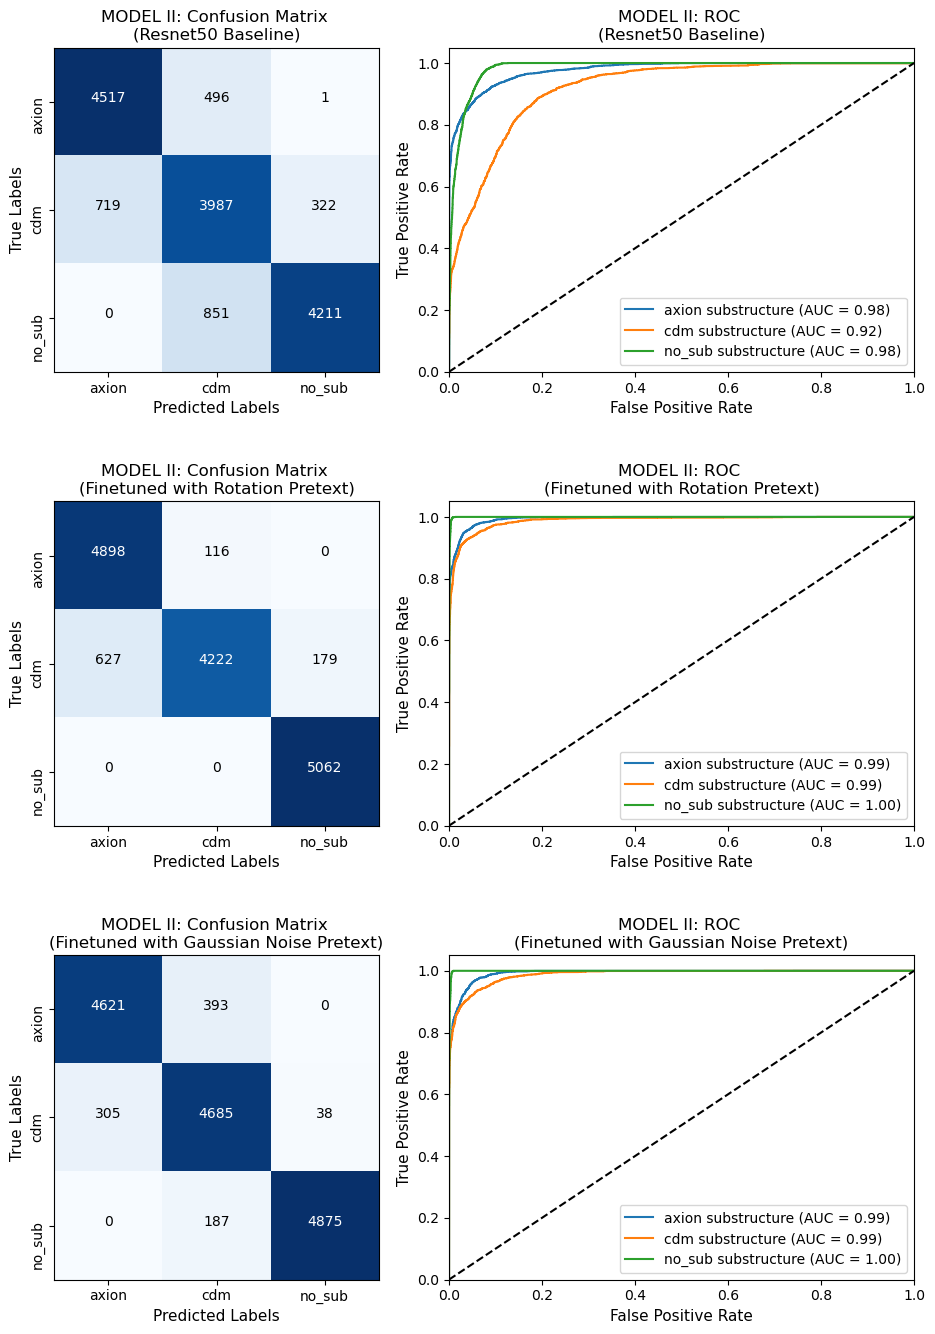

In [28]:
datasets = {
    "Resnet50 Baseline": (y_true_baseline, y_pred_baseline),
    "Finetuned with Rotation Pretext": (y_true_finetuning_rotation, y_pred_finetuning_rotation),
    "Finetuned with Gaussian Noise Pretext": (y_true_finetuning_gaussian, y_pred_finetuning_gaussian)
}

plt.figure(figsize=(12, 16)) 
for idx, (title, (y_true, y_pred)) in enumerate(datasets.items()):
    cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
    plt.subplot(len(datasets), 2, 2*idx+1)
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title(f'MODEL II: Confusion Matrix \n({title})', fontsize=12)
    plt.xlabel('Predicted Labels', fontsize=11)
    plt.ylabel('True Labels', fontsize=11)

    tick_marks = np.arange(len(class_indices))
    plt.xticks(tick_marks, class_indices)
    plt.yticks(tick_marks, class_indices, rotation=90)

    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.subplot(len(datasets), 2, 2*idx+2)
    for class_name, i in class_indices.items():
        plt.plot(fpr[i], tpr[i], label=f"{class_name} substructure (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title(f'MODEL II: ROC \n({title})', fontsize=12)
    plt.xlabel('False Positive Rate', fontsize=11)
    plt.ylabel('True Positive Rate', fontsize=11)
    plt.legend(loc="lower right")

plt.subplots_adjust(wspace=0, hspace=0.4)
plt.show()
